# Project 1: Market Risk — VaR, ES, and Copulas

**Names of all group members:**
- Tellef Skofteland (tellef.skofteland@epfl.ch)
- Felix Reinemo (felix.reinemo@epfl.ch)
- Erling Fjelstad (erling.fjelstad@epfl.ch)


---

## 0) Setup

Creates necessary folders and sets hyperparameters for the project.

In [340]:
# If a package import fails, install it in your environment, e.g.:
# %pip install yfinance arch copulae statsmodels seaborn

import os
import numpy as np
import copulae
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import statsmodels as sm
from arch import arch_model
import scipy.stats as st
import statsmodels.tsa.stattools as smt
import matplotlib.pyplot as plt
import seaborn as sns


# your own script with helper functions, if any
# import utils as U

# Locate the Project 1 directory to this notebook's working directory
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / 'data'
OUT_DIR = PROJECT_DIR / 'output'
for d in [DATA_DIR, OUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Parameters
TICKERS = ['AAPL', 'META', 'JPM']
START = '2023-01-01'
END = '2025-06-30'
WINDOW = 252                        # rolling/first-window length in periods (days)
ALPHAS = [0.95, 0.99]

seed = 0
np.random.seed(seed)

print('Project dir:', PROJECT_DIR)
print('Output ->', OUT_DIR)

Project dir: c:\Users\Telle\Documents\EPFL\Quantitative\QRM_project1
Output -> c:\Users\Telle\Documents\EPFL\Quantitative\QRM_project1\output


Download and save Adjusted Close for the tickers over the given range into `data/` (CSV per ticker).

In [341]:
import yfinance as yf

print('Downloading data to', DATA_DIR)
for t in TICKERS:
    print(f'  -> {t}')
    df = yf.download(t, start=START, end=END, progress=False, auto_adjust=False)
    if df.empty:
        print(f'     Warning: no data for {t}')
        continue
    out = df.reset_index()
    out = out[['Date', 'Adj Close']]
    out.to_csv(DATA_DIR / f'{t}.csv', index=False)
print('Done.')

  -> AAPL
  -> META
  -> JPM
Done.


Now, load the data back from CSVs

In [342]:
files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith('.csv')]
frames = []
for f in files:
    p = os.path.join(DATA_DIR, f)
    df = pd.read_csv(p, parse_dates=['Date'])
    df = df[['Date', 'Adj Close']]
    # Coerce to numeric and drop malformed rows
    df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')
    df = df.dropna(subset=['Date', 'Adj Close'])
    df = df.rename(columns={'Adj Close': f.split('.')[0]})
    df = df.set_index('Date').sort_index()
    frames.append(df)
prices = pd.concat(frames, axis=1).dropna(how='all')

print(prices.head(3))

                  AAPL         JPM        META
Date                                          
2023-01-03  123.211197  125.492203  123.975716
2023-01-04  124.482033  126.662437  126.589615
2023-01-05  123.161949  126.634392  126.162247


## 1) Empirical stylized facts


1.  Construct daily log-returns for AAPL, MSFT, JPM; plot series and comment on trends/volatility.
2.  Estimate correlation functions of returns and absolute returns across assets and lags 0–25; comment.
3.  QQ plots vs Normal; perform Jarque–Bera test and discuss normality.


In [343]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

log_returns = np.log(prices / prices.shift(1)).dropna()


fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Scatter(x = log_returns.index, y=log_returns['AAPL'], name="AAPL"), row=1, col=1)
fig.add_trace(go.Scatter(x = log_returns.index, y=log_returns["JPM"], name="JPM"), row=1, col=2)
fig.add_trace(go.Scatter(x = log_returns.index, y=log_returns["META"], name="META"), row=1, col=3)
fig.update_layout(
    title=dict(
        text="Log returns"
    ),
    xaxis=dict(
        title=dict(
            text="Date"
        )
    ),
    yaxis=dict(
        title=dict(
            text="Log returns"
        )
    ),
    legend=dict(

    ),

)
fig.show()

### b)

In [344]:
sns.set(style="whitegrid")

MAX_LAG = 25

def compute_ccf_matrix(df, max_lag=25, abs_values=False):
    """
    Compute cross-correlation matrix for all pairs of series in df.
    Returns a dictionary {(i,j): array of correlations at lags 0..max_lag}
    """
    if abs_values:
        df = df.abs()
    out = {}
    cols = df.columns
    for i in cols:
        for j in cols:
            ccf_values = smt.ccf(df[i], df[j], adjusted=False)[:max_lag+1]
            out[(i, j)] = ccf_values
    return out

# Compute for raw and absolute returns
ccf_raw = compute_ccf_matrix(log_returns, MAX_LAG)
ccf_abs = compute_ccf_matrix(log_returns, MAX_LAG, abs_values=True)



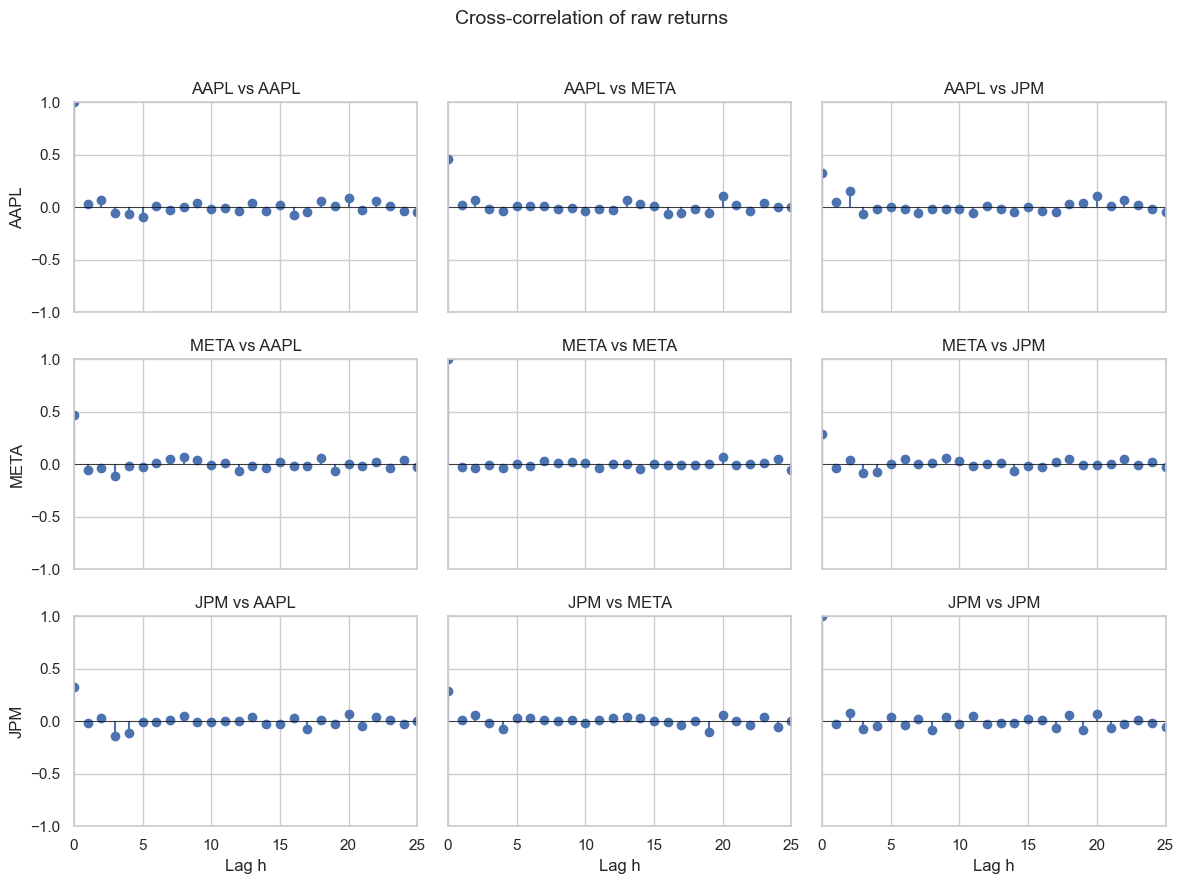

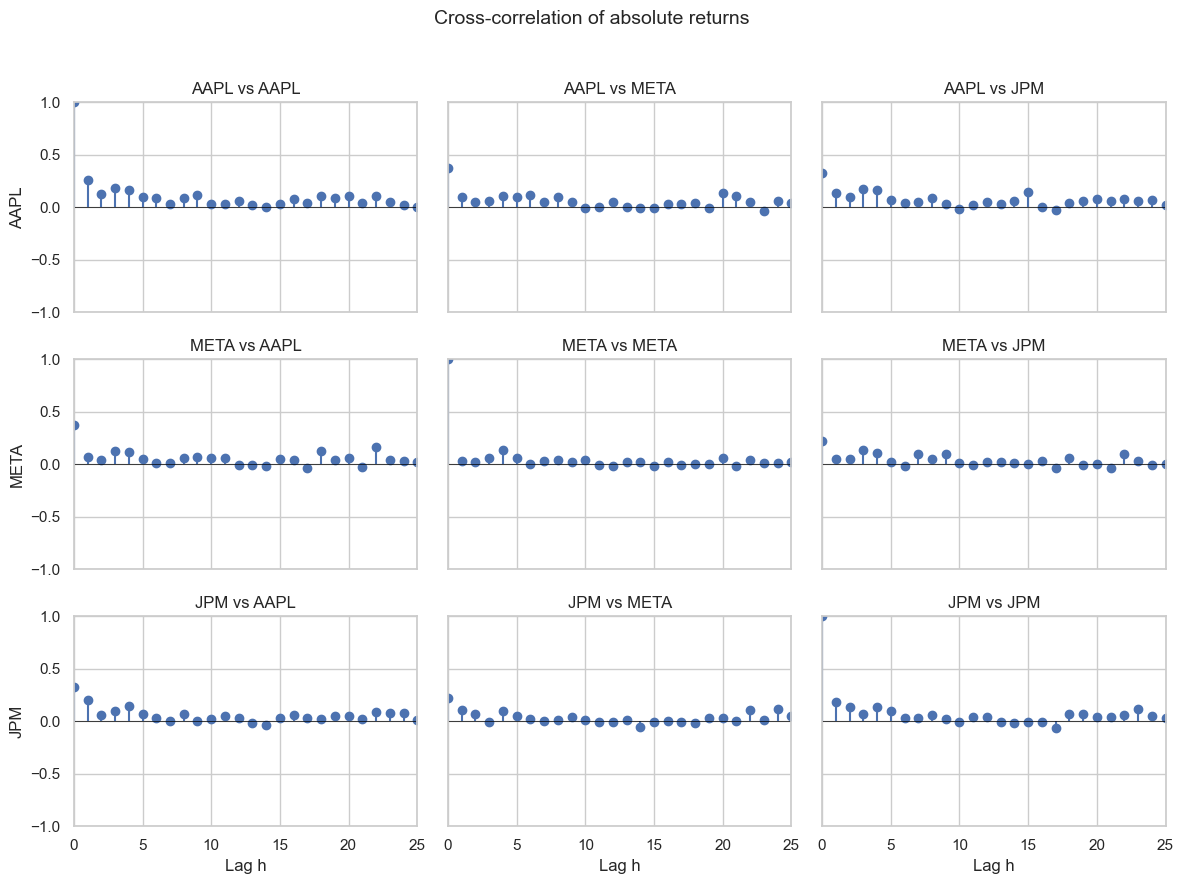

In [345]:
def plot_ccfs(ccf_dict, tickers, max_lag, title):
    k = len(tickers)
    fig, axes = plt.subplots(k, k, figsize=(4*k, 3*k), sharex=True, sharey=True)
    lags = np.arange(0, max_lag+1)
    
    for i, t1 in enumerate(tickers):
        for j, t2 in enumerate(tickers):
            ax = axes[i, j]
            ax.stem(lags, ccf_dict[(t1, t2)], basefmt=" ")
            ax.axhline(0, color='black', lw=0.5)
            ax.set_xlim(0, max_lag)
            ax.set_ylim(-1, 1)
            if i == k-1:
                ax.set_xlabel(f"Lag h")
            if j == 0:
                ax.set_ylabel(f"{t1}")
            ax.set_title(f"{t1} vs {t2}")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot raw and absolute return correlations
tickers = ['AAPL', 'META', 'JPM']
plot_ccfs(ccf_raw, tickers, MAX_LAG, "Cross-correlation of raw returns")
plot_ccfs(ccf_abs, tickers, MAX_LAG, "Cross-correlation of absolute returns")


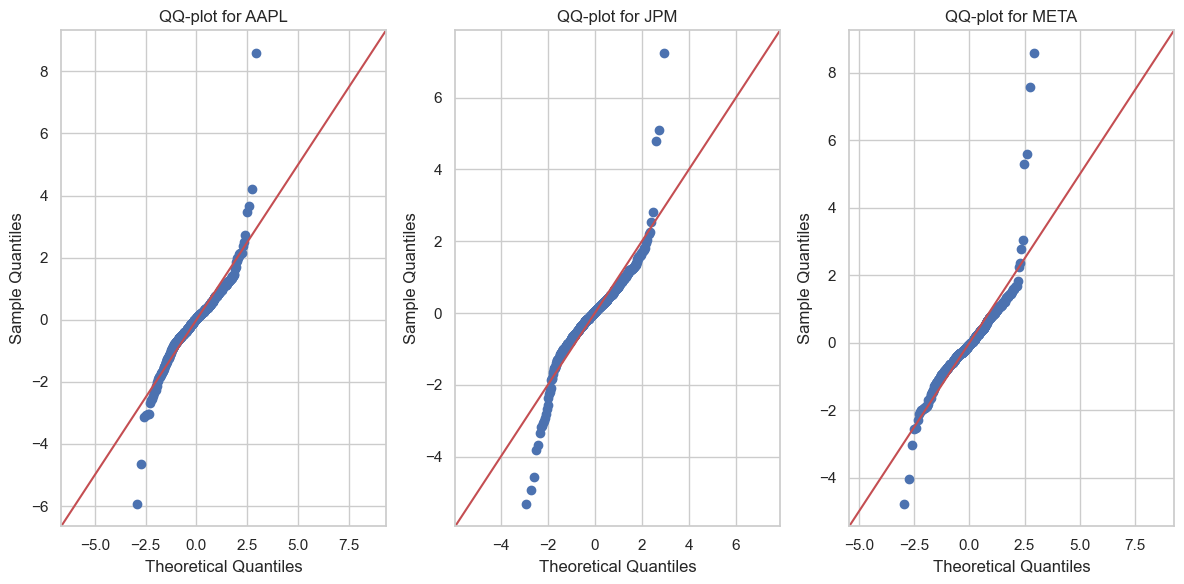

In [346]:
import statsmodels.api as sm
   
fig, ax = plt.subplots(1, 3, figsize = (12,6))
sm.qqplot(log_returns["AAPL"], line="45", fit=True, ax=ax[0]);
ax[0].set_title("QQ-plot for AAPL")
sm.qqplot(log_returns["JPM"], line="45", fit=True, ax=ax[1]);
ax[1].set_title("QQ-plot for JPM")
sm.qqplot(log_returns["META"], line="45", fit=True, ax=ax[2]);
ax[2].set_title("QQ-plot for META")
fig.set_tight_layout(tight=6)
plt.show()

In [347]:
columns = log_returns.columns
JB_list = []
pvalue_list = []
skew_list = []
kurtosis_list = []

# Compute JB test for each column
for col in columns:
    JB, JBpv, skew, kurtosis = sm.stats.stattools.jarque_bera(log_returns[col])
    JB_list.append(JB)
    pvalue_list.append(JBpv)
    skew_list.append(skew)
    kurtosis_list.append(kurtosis)

# Create results table
results_table = pd.DataFrame({
    'JB-value': JB_list,
    'p-value': pvalue_list,
    'Skewness': skew_list,
    'Kurtosis': kurtosis_list
}, index=columns)

print(results_table)

         JB-value  p-value  Skewness   Kurtosis
AAPL  3619.305920      0.0  0.489655  14.776783
JPM   2203.497910      0.0 -0.044784  12.220326
META  7608.770494      0.0  1.865346  19.723275


## 2) First-window modeling: VaR, ES, and distributions

Use the first estimation window W (days) on each asset separately with losses L = −R.
Compare: 

- historical,
- Gaussian,
- Student-t,
- AR(p)+GARCH(1,1) with Normal/Student-t,
- Filtered Historical Simulation (FHS).

### a) Historical simulation

In [348]:
# TODO
# for the gaussian/student-t fitting, you can use
# stats.norm.fit(data) / stats.t.fit(data)


losses = - log_returns[:252]


def historical(losses, alpha):
   """
   Calculates historical VaR and ES
  
   losses: array-like of losses (L = -R)
   alpha: confidence level
   """
   L = pd.Series(losses).dropna()
   VaR = np.percentile(L, 100 * alpha)
   tail = L[L >= VaR]
   ES = tail.mean()


   return float(VaR), float(ES)

In [349]:
alphas = [0.95, 0.99]
results = []


for stock in losses.columns:
   row = {'Stock': stock}
   for alpha in alphas:
       VaR, ES = historical(losses[stock], alpha)
       row[f'VaR_{int(alpha*100)}'] = VaR
       row[f'ES_{int(alpha*100)}'] = ES
   results.append(row)


summary_df = pd.DataFrame(results)
print(summary_df)

  Stock    VaR_95     ES_95    VaR_99     ES_99
0  AAPL  0.017587  0.026807  0.032997  0.040701
1   JPM  0.018300  0.030295  0.037581  0.047523
2  META  0.027310  0.035920  0.043077  0.044618


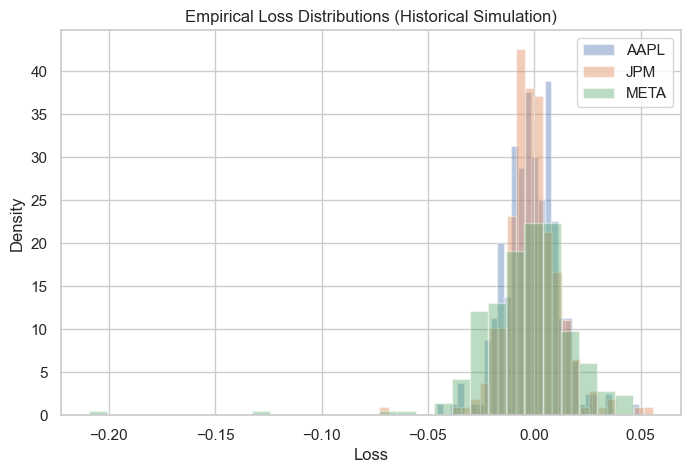

In [350]:
plt.figure(figsize=(8, 5))
for stock in losses.columns:
   plt.hist(losses[stock], bins=30, density=True, alpha=0.4, label=stock)
plt.xlabel("Loss")
plt.ylabel("Density")
plt.title("Empirical Loss Distributions (Historical Simulation)")
plt.legend()
plt.grid(True)
plt.show()

### b) Gaussian

In [351]:
def gaussian(loss, alpha):
   """
   Calculates Gaussian VaR and ES
  
   loss: array-like of losses (L = -R)
   alpha: confidence level
   """


   L = pd.Series(loss).dropna()
   mu_L, sigam_L = stats.norm.fit(L)
   z = stats.norm.ppf(alpha)
  
   VaR = mu_L + sigam_L * z
   ES = mu_L + sigam_L * stats.norm.pdf(z) / (1 - alpha)


   return float(VaR), float(ES), mu_L, sigam_L

In [352]:
gauss_results = []
for stock in losses.columns:
   row = {'Stock': stock}
   for alpha in alphas:
       VaR, ES, mu_L, sigma_L = gaussian(losses[stock], alpha)
       row[f'VaR_{int(alpha*100)}'] = VaR
       row[f'ES_{int(alpha*100)}'] = ES
   row['Mu_L'] = mu_L
   row['Sigma_L'] = sigma_L
   gauss_results.append(row)


gaussian_summary = pd.DataFrame(gauss_results)
print(gaussian_summary)

  Stock    VaR_95     ES_95    VaR_99     ES_99      Mu_L   Sigma_L
0  AAPL  0.019421  0.024738  0.028092  0.032404 -0.001509  0.012724
1   JPM  0.020292  0.025723  0.029149  0.033553 -0.001085  0.012996
2  META  0.035232  0.045215  0.051513  0.059608 -0.004061  0.023889


### c) Student-t:

In [353]:
def student_t(loss, alpha):
   """
   Calculates Student-t VaR and ES
  
   loss: array-like of losses (L = -R)
   alpha: confidence level
   """


   L = pd.Series(loss).dropna()
   df, mu_L, sigma_L = stats.t.fit(L, floc=0)
   t_alpha = stats.t.ppf(alpha, df)
  
   VaR = mu_L + sigma_L * t_alpha
   ES = mu_L + (sigma_L * (df + t_alpha**2) / (df - 1)) * stats.t.pdf(t_alpha, df) / (1 - alpha)


   return float(VaR), float(ES), mu_L, sigma_L, df

In [354]:
t_results = []
for stock in losses.columns:
   row = {'Stock': stock}
   for alpha in alphas:
       VaR, ES, mu_L, sigma_L, df = student_t(losses[stock], alpha)
       row[f'VaR_{int(alpha*100)}'] = VaR
       row[f'ES_{int(alpha*100)}'] = ES
   row['Mu_L'] = mu_L
   row['Sigma_L'] = sigma_L
   row['DF'] = df
   t_results.append(row)


student_t_summary = pd.DataFrame(t_results)
print(student_t_summary)

  Stock    VaR_95     ES_95    VaR_99     ES_99  Mu_L   Sigma_L        DF
0  AAPL  0.020559  0.028166  0.032544  0.040939     0  0.010846  6.978381
1   JPM  0.019720  0.029877  0.034972  0.049182     0  0.009161  3.870265
2  META  0.032972  0.048779  0.056993  0.078055     0  0.015750  4.272006


### d) Conditional parametric:

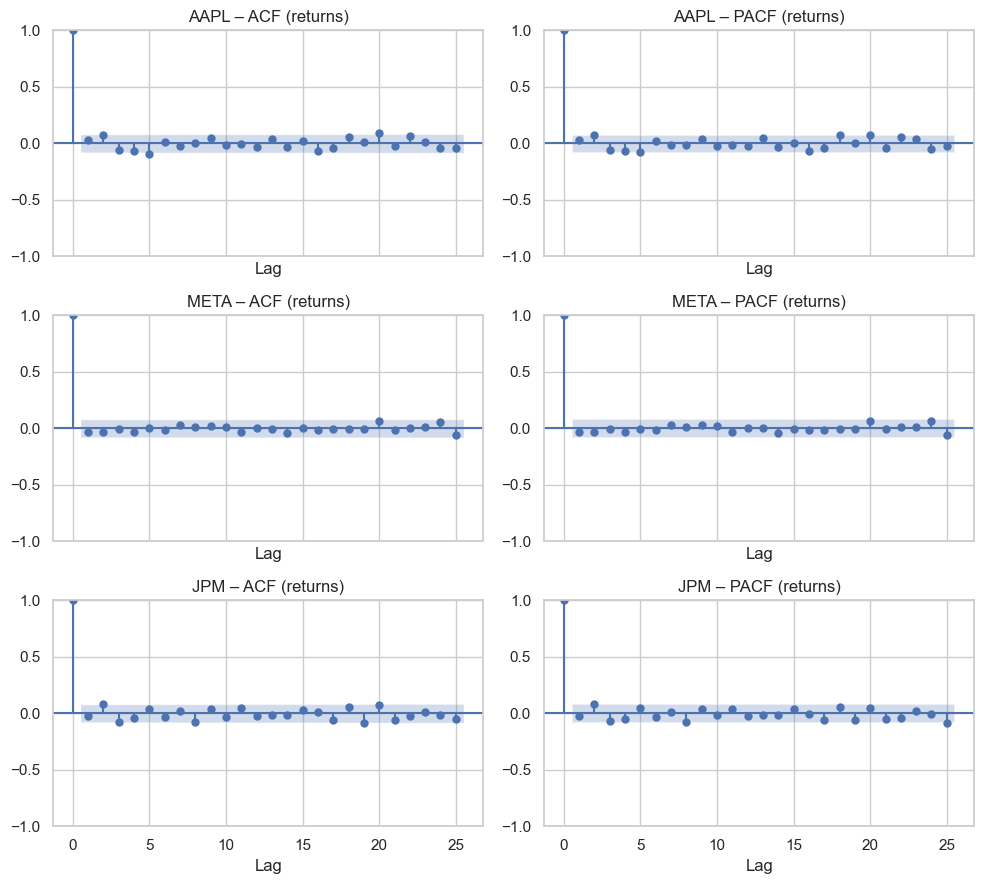

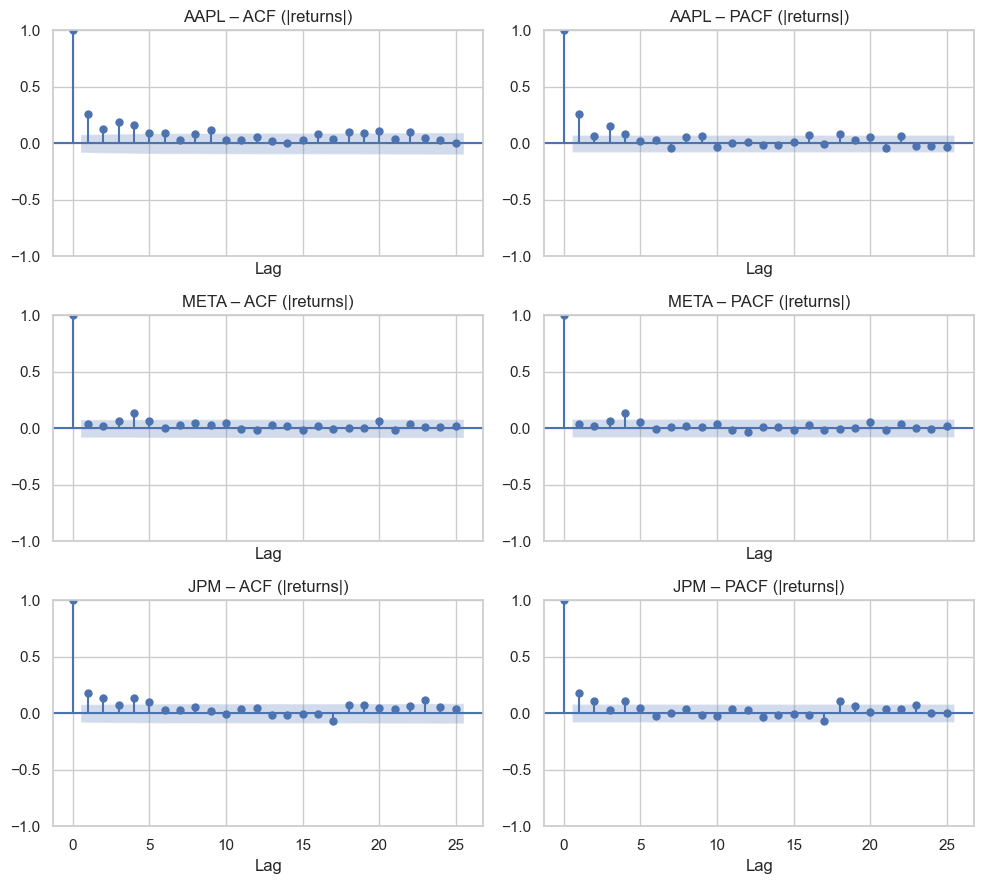

In [355]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

MAX_LAG = 25
tickers = ['AAPL', 'META', 'JPM']

def plot_acf_pacf(df, max_lag=25, abs_values=False, title_suffix=""):
    if abs_values:
        df = df.abs()

    k = len(df.columns)
    fig, axes = plt.subplots(k, 2, figsize=(10, 3*k), sharex=True)
    
    for i, col in enumerate(df.columns):
        series = df[col].dropna()
        ax_acf  = axes[i, 0]
        ax_pacf = axes[i, 1]

        plot_acf(series, lags=max_lag, ax=ax_acf)
        plot_pacf(series, lags=max_lag, ax=ax_pacf, method="ywm")

        ax_acf.set_title(f"{col} – ACF{title_suffix}")
        ax_pacf.set_title(f"{col} – PACF{title_suffix}")
        ax_acf.set_xlabel("Lag")
        ax_pacf.set_xlabel("Lag")

    plt.tight_layout()
    plt.show()

# ACF/PACF of raw returns
plot_acf_pacf(log_returns[tickers], MAX_LAG, abs_values=False, title_suffix=" (returns)")

# ACF/PACF of absolute returns
plot_acf_pacf(log_returns[tickers], MAX_LAG, abs_values=True, title_suffix=" (|returns|)")


In [356]:
def fit_ar_garch(losses, p):


   x = pd.Series(losses).dropna()


   am = arch_model(x, vol='Garch', p=1, q=1, dist='normal', mean='AR', lags=p, rescale=False)
   res = am.fit(disp='off',show_warning=False)



   return res


def forecast_ar_garch(res, alpha):


   forecast = res.forecast(horizon=1)


   mu_L = forecast.mean.iloc[-1, 0]
   sigma_L = np.sqrt(forecast.variance.iloc[-1, 0])


   z = stats.norm.ppf(alpha)
   VaR = mu_L + sigma_L * z
   ES = mu_L + sigma_L * stats.norm.pdf(z) / (1 - alpha)


   return float(VaR), float(ES), mu_L, sigma_L


def ar_garch(losses, p, alpha):


   res = fit_ar_garch(losses, p)
   VaR, ES, mu_L, sigma_L = forecast_ar_garch(res, alpha)
  
   return float(VaR), float(ES), mu_L, sigma_L

In [357]:
p = 0 # AR order


ar_garch_results = []
for stock in losses.columns:
  row = {'Stock': stock}
  for alpha in alphas:
      VaR, ES, mu_L, sigma_L = ar_garch(losses[stock], p, alpha)
      row[f'VaR_{int(alpha*100)}'] = VaR
      row[f'ES_{int(alpha*100)}'] = ES
  row['Mu_L'] = mu_L
  row['Sigma_L'] = sigma_L
  ar_garch_results.append(row)


ar_garch_summary = pd.DataFrame(ar_garch_results)
print(ar_garch_summary)

  Stock    VaR_95     ES_95    VaR_99     ES_99      Mu_L   Sigma_L
0  AAPL  0.019651  0.025015  0.028400  0.032750 -0.001465  0.012838
1   JPM  0.013859  0.017767  0.020232  0.023401 -0.001523  0.009352
2  META  0.031938  0.040942  0.046622  0.053923 -0.003502  0.021546


### e) Filtered historical simulation:

In [358]:
def fhs(res, alpha, M):


   rng = np.random.default_rng(0)


   std_resid = res.resid / res.conditional_volatility
   std_resid = std_resid.dropna().to_numpy()


   forecast = res.forecast(horizon=1)
   mu = float(forecast.mean.iloc[-1, 0])
   sigma = float(np.sqrt(forecast.variance.iloc[-1, 0]))
  
   z = rng.choice(std_resid, size=M, replace=True)


   simulated_losses = mu + sigma * z


   VaR = np.percentile(simulated_losses, 100 * alpha)
   ES = simulated_losses[simulated_losses >= VaR].mean()


   return float(VaR), float(ES), simulated_losses, mu, sigma, std_resid

In [359]:
M = 1000


fhs_results = []
for stock in losses.columns:
  row = {'Stock': stock}
  res = fit_ar_garch(losses[stock], p)
  for alpha in alphas:
      VaR, ES, _, _, _, _, = fhs(res, alpha, M)
      row[f'VaR_{int(alpha*100)}'] = VaR
      row[f'ES_{int(alpha*100)}'] = ES
  fhs_results.append(row)


fhs_summary = pd.DataFrame(fhs_results)
print(fhs_summary)

  Stock    VaR_95     ES_95    VaR_99     ES_99
0  AAPL  0.019915  0.030713  0.036666  0.045700
1   JPM  0.015021  0.023556  0.032808  0.037269
2  META  0.023794  0.029585  0.035499  0.037154


### Plotting distributions:

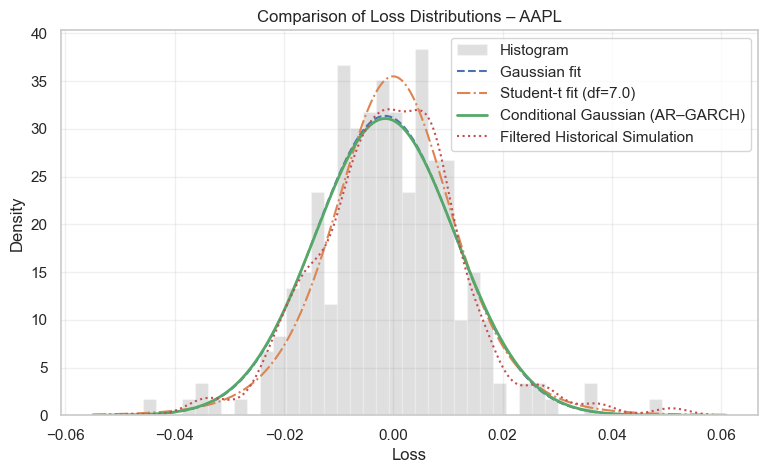

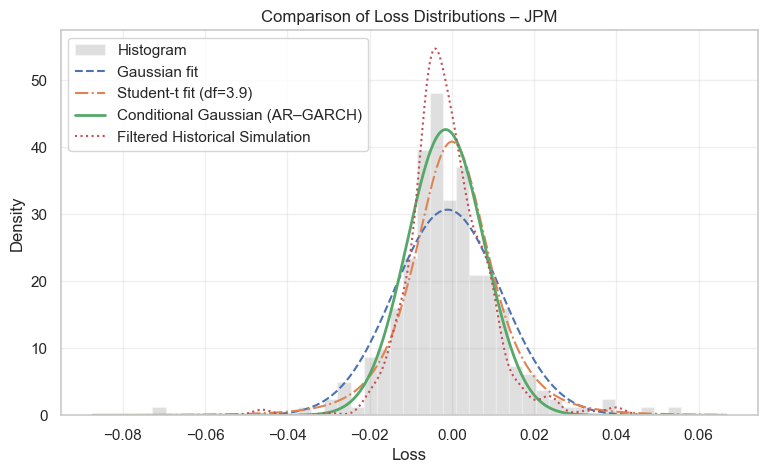

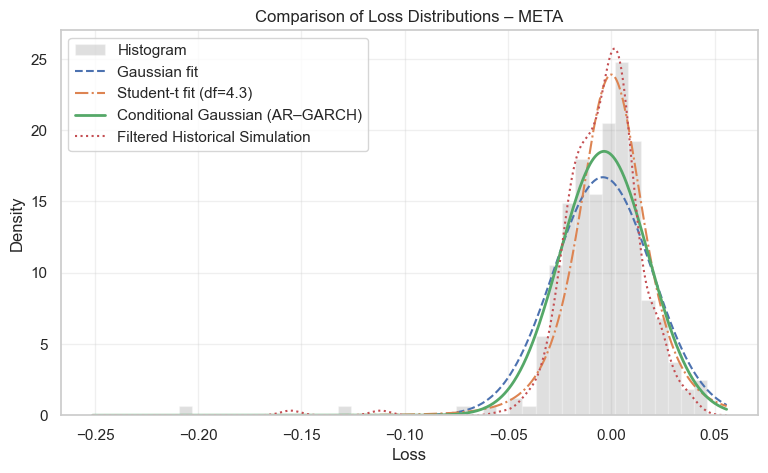

In [360]:
def plot_loss_distributions(stock,
                           L,
                           mu_g, sigma_g,            # Gaussian parameters
                           df_t, mu_t, sigma_t,      # Student-t parameters
                           mu_cond, sigma_cond,      # AR–GARCH conditional Gaussian
                           fhs_sim_losses=None,      # Optional: simulated FHS losses
                           bins=40):


   L = pd.Series(L).dropna()


   # x-range covering all methods
   xs = np.linspace(
       min(L.min(), np.percentile(fhs_sim_losses, 0.1) if fhs_sim_losses is not None else L.min()) * 1.2,
       max(L.max(), np.percentile(fhs_sim_losses, 99.9) if fhs_sim_losses is not None else L.max()) * 1.2,
       800
   )


   # PDFs
   pdf_g   = stats.norm.pdf(xs, loc=mu_g,       scale=sigma_g)
   pdf_t   = stats.t.pdf  (xs, df=df_t, loc=mu_t, scale=sigma_t)
   pdf_cond = stats.norm.pdf(xs, loc=mu_cond,   scale=sigma_cond)  # conditional parametric


   if fhs_sim_losses is not None:
       kde_fhs = stats.gaussian_kde(fhs_sim_losses)
       pdf_fhs = kde_fhs(xs)
   else:
       pdf_fhs = None


   # Plot
   plt.figure(figsize=(9, 5))


   # Histogram of empirical losses
   plt.hist(L, bins=bins, density=True, alpha=0.25, color="gray", label="Histogram")


   # Unconditional Gaussian
   plt.plot(xs, pdf_g,   label="Gaussian fit", linestyle='--')


   # Student-t
   plt.plot(xs, pdf_t,   label=f"Student-t fit (df={df_t:.1f})", linestyle='-.')


   # Conditional Gaussian (AR–GARCH)
   plt.plot(xs, pdf_cond, label="Conditional Gaussian (AR–GARCH)", linestyle='-', linewidth=2)


   # FHS
   if pdf_fhs is not None:
       plt.plot(xs, pdf_fhs, label="Filtered Historical Simulation", linestyle=':')


   plt.title(f"Comparison of Loss Distributions – {stock}")
   plt.xlabel("Loss")
   plt.ylabel("Density")
   plt.grid(True, alpha=0.3)
   plt.legend()
   plt.savefig(OUT_DIR / f'loss_distribution_{stock}.png')
   plt.show()




# ---- loop over assets ----
for stock in losses.columns:
   L = losses[stock]


   # Gaussian (unconditional) parameters from your helper
   _, _, mu_g, sigma_g = gaussian(L, 0.95)


   # Student-t parameters from your helper
   _, _, mu_t, sigma_t, df_t = student_t(L, 0.95)


   # Fit AR–GARCH once
   res = fit_ar_garch(L, p)


   # Conditional mean / sigma for t = W+1
   # alpha only matters for VaR/ES; mu_L, sigma_L are the same regardless of alpha
   _, _, mu_cond, sigma_cond = forecast_ar_garch(res, alpha=0.95)


   # FHS simulated losses
   _, _, fhs_sim, *rest = fhs(res, 0.95, M=1000)  # adjust unpacking to your fhs signature


   plot_loss_distributions(
       stock,
       L,
       mu_g, sigma_g,
       df_t, mu_t, sigma_t,
       mu_cond, sigma_cond,
       fhs_sim_losses=fhs_sim
   )









## 3) Rolling-window backtesting of VaR and ES

Use a rolling window of size W to produce 1-step-ahead VaR/ES at 95% and 99% for each method in Exercise 2. Then, implement the following statistical tests:

- VaR backtests: Kupiec POF and Christoffersen independence tests.
- ES backtest: Acerbi–Székely Z1 test.

In [361]:
alpha_vals = [0.95, 0.99]
methods = ['Historical', 'Gaussian', 'Student-t', 'AR-GARCH', 'FHS']

var_tables = {alpha: pd.DataFrame(index=losses.columns, columns=methods) for alpha in alpha_vals}
es_tables = {alpha: pd.DataFrame(index=losses.columns, columns=methods) for alpha in alpha_vals}

# tables to store mu, sigma and df (t-dist) for each method needed for problem 3b)
mu_sigma_tables = {alpha: {method: pd.DataFrame(index=losses.columns, columns=['Mu_L', 'Sigma_L', 'Df_L', 'Std_Resid_L']) for method in methods if method != 'Historical'} for alpha in alpha_vals}


W = 252
T = log_returns.shape[0] - W - 1

for stock in log_returns.columns:
    L = -log_returns[stock]

    for alpha in alpha_vals:

        # Lists to store rolling VaR and ES
        var_list_hist = []
        es_list_hist = []
        var_list_gau = []
        es_list_gau = []
        var_list_t = []
        es_list_t = []
        var_list_ag = []
        es_list_ag = []
        var_list_fhs = []
        es_list_fhs = []

        # Lists to store mu, sigma, df
        mu_list_gau = []
        sigma_list_gau = []
        mu_list_t = []
        sigma_list_t = []
        df_list_t = []
        mu_list_ag = []
        sigma_list_ag = []
        std_resid_list_fhs = []
        mu_list_fhs = []
        sigma_list_fhs = []



        for i in range(T):

            L_window = L[i:i+W]

            # Historical
            VaR_his, ES_his = historical(L_window, alpha)
            var_list_hist.append(VaR_his)
            es_list_hist.append(ES_his)

            # # Gaussian
            VaR_gau, ES_gau, mu_gauss, sigma_gauss = gaussian(L_window, alpha)
            var_list_gau.append(VaR_gau)
            es_list_gau.append(ES_gau)
            mu_list_gau.append(mu_gauss)
            sigma_list_gau.append(sigma_gauss)

            # # Student-t
            VaR_t, ES_t, mu_t, sigma_t, df_t = student_t(L_window, alpha)
            var_list_t.append(VaR_t)
            es_list_t.append(ES_t)

            mu_list_t.append(mu_t)
            sigma_list_t.append(sigma_t)
            df_list_t.append(df_t)
     

            # # AR-GARCH
            VaR_ag, ES_ag, mu_ag, sigma_ag = ar_garch(L_window, p=0, alpha=alpha)
            var_list_ag.append(VaR_ag)
            es_list_ag.append(ES_ag)
            mu_list_ag.append(mu_ag)
            sigma_list_ag.append(sigma_ag)

            # # FHS
            res = fit_ar_garch(L_window, p=0)
            VaR_fhs, ES_fhs, _, mu_fhs, sigma_fhs, std_resid_fhs = fhs(res, alpha, M=1000)
            var_list_fhs.append(VaR_fhs)
            es_list_fhs.append(ES_fhs)
            mu_list_fhs.append(mu_fhs)
            sigma_list_fhs.append(sigma_fhs)
            std_resid_list_fhs.append(std_resid_fhs)


        # Store VaR and ES in tables
  
     
        var_tables[alpha].loc[stock, 'Historical'] = var_list_hist
        es_tables[alpha].loc[stock, 'Historical'] = es_list_hist
        var_tables[alpha].loc[stock, 'Gaussian'] = var_list_gau
        es_tables[alpha].loc[stock, 'Gaussian'] = es_list_gau
        var_tables[alpha].loc[stock, 'Student-t'] = var_list_t
        es_tables[alpha].loc[stock, 'Student-t'] = es_list_t
        var_tables[alpha].loc[stock, 'AR-GARCH'] = var_list_ag
        es_tables[alpha].loc[stock, 'AR-GARCH'] = es_list_ag
        var_tables[alpha].loc[stock, 'FHS'] = var_list_fhs
        es_tables[alpha].loc[stock, 'FHS'] = es_list_fhs


        # Store mu and sigma for later use
        mu_sigma_tables[alpha]['Gaussian'].loc[stock, 'Mu_L'] = mu_list_gau
        mu_sigma_tables[alpha]['Gaussian'].loc[stock, 'Sigma_L'] = sigma_list_gau
        mu_sigma_tables[alpha]['Student-t'].loc[stock, 'Mu_L'] = mu_list_t
        mu_sigma_tables[alpha]['Student-t'].loc[stock, 'Sigma_L'] = sigma_list_t
        mu_sigma_tables[alpha]['Student-t'].loc[stock, 'Df_L'] = df_list_t
        mu_sigma_tables[alpha]['AR-GARCH'].loc[stock, 'Mu_L'] = mu_list_ag
        mu_sigma_tables[alpha]['AR-GARCH'].loc[stock, 'Sigma_L'] = sigma_list_ag
        mu_sigma_tables[alpha]['FHS'].loc[stock, 'Mu_L'] = mu_list_fhs
        mu_sigma_tables[alpha]['FHS'].loc[stock, 'Sigma_L'] = sigma_list_fhs
        mu_sigma_tables[alpha]['FHS'].loc[stock, 'Std_Resid_L'] = std_resid_list_fhs


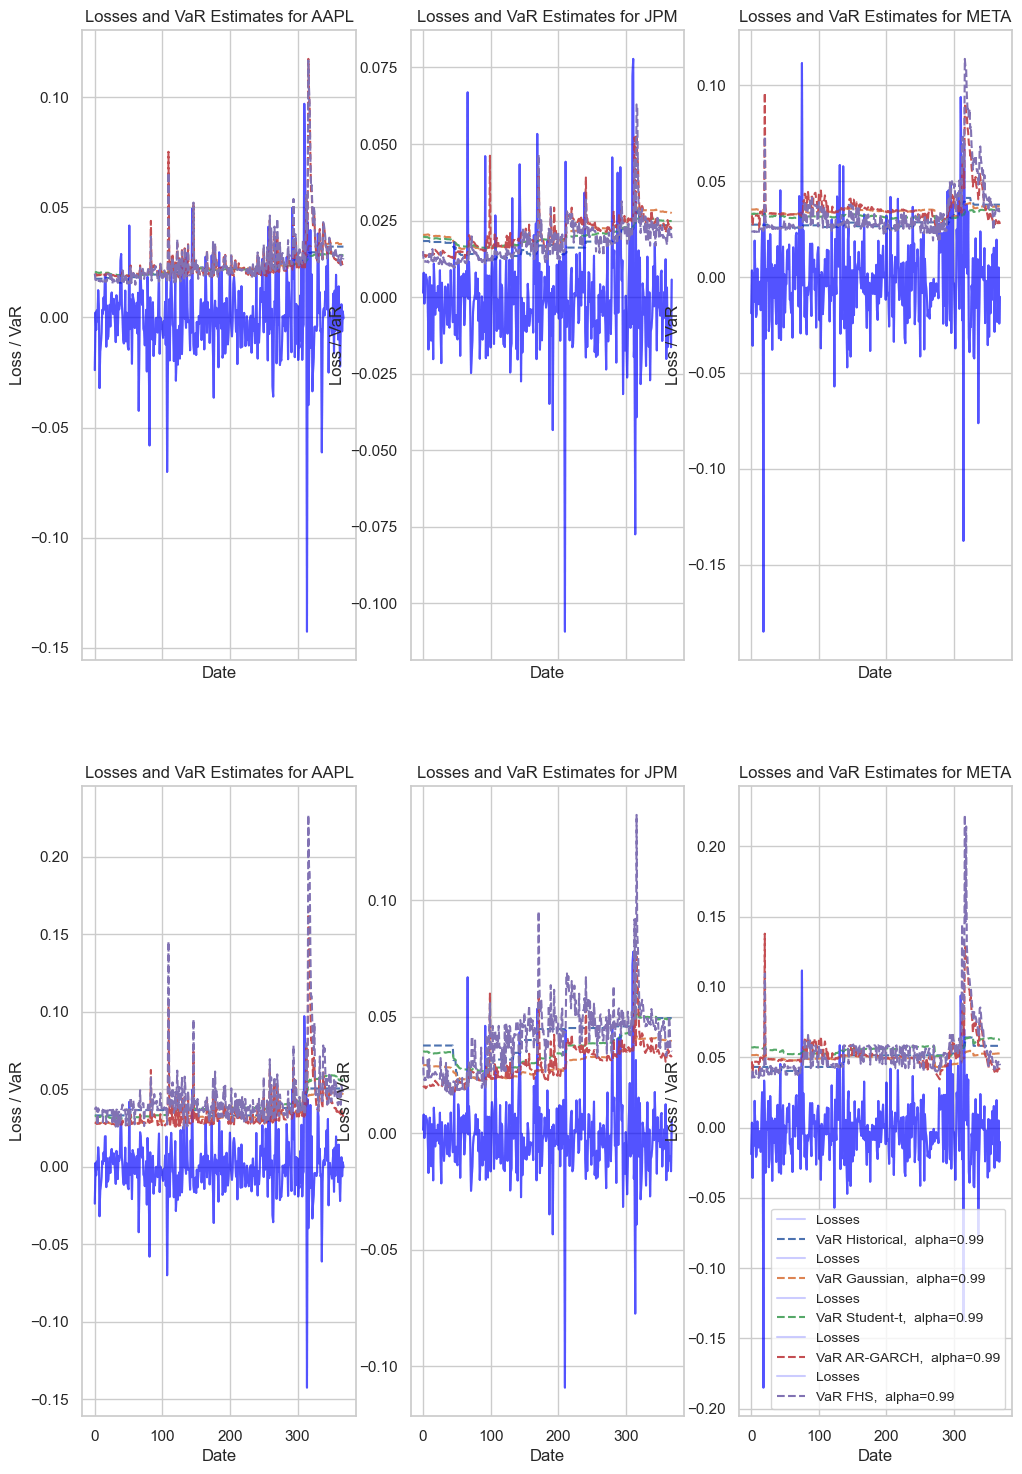

In [ ]:
# Plot the VaR time series for each stock and method as well as the losses
fig, axes = plt.subplots(2, 3, figsize=(12, 6*len(log_returns.columns)), sharex=True)
for i, stock in enumerate(log_returns.columns):
    L = -log_returns[stock]


    for method in methods:
        for j, alpha in enumerate(alpha_vals):
            axes[j, i].plot(-log_returns[stock][W+1:].values, label='Losses', color="blue", alpha=0.2)
            VaR_series = var_tables[alpha].loc[stock, method]
            axes[j, i].plot(VaR_series, label=f'VaR {method},  alpha={alpha}', linestyle='--')

            axes[j, i].set_title(f'Losses and VaR Estimates for {stock}')
            axes[j, i].set_xlabel('Date')
            axes[j, i].set_ylabel('Loss / VaR')
            
plt.grid(True)
plt.legend(fontsize='small')
plt.show()

In [363]:
def kupiec_pof_test(L, VaR_hat, alpha):
    """
    Kupiec POF test.
    L : array-like of realized losses (length T)
    VaR_hat : array-like of 1-step-ahead VaR forecasts at level alpha (length T)
    alpha : VaR level (e.g. 0.95)
    Returns: dict with N, p_hat, p_nominal, LR_pof, pvalue
    """
    L = np.asarray(L)
    VaR_hat = np.asarray(VaR_hat)
    T = len(L)
    I = (L > VaR_hat).astype(int)
    N = I.sum()
    p_hat = N / T
    p_nom = 1.0 - alpha

    # avoid log(0) by bounding probabilities (very small epsilon)
    eps = 1e-12
    p_hat_b = np.clip(p_hat, eps, 1-eps)
    p_nom_b = np.clip(p_nom, eps, 1-eps)

    logL0 = (T - N) * np.log(1 - p_nom_b) + N * np.log(p_nom_b)
    logL1 = (T - N) * np.log(1 - p_hat_b) + N * np.log(p_hat_b)

    LR_pof = -2.0 * (logL0 - logL1)
    pvalue = 1 - stats.chi2.cdf(LR_pof, df=1)
    passed = pvalue > 0.05
    return {
        'p_hat': p_hat, 'p_nom': p_nom,
        'LR_pof': float(LR_pof), 'pvalue': float(pvalue), 'I': I, 'passed': passed
    }

def christoffersen_independence_test(I):
    """
    Independence test for the sequence I_t.
    I: array-like of 0/1 indicators, length T
    Returns dictionary with transition counts, LR_ind, pvalue and estimated pis.
    """
    I = np.asarray(I).astype(int)
    T = len(I)
    # Find the number of different transitions:
    N00 = N01 = N10 = N11 = 0
    for t in range(1, T):
        prev = I[t-1]
        cur = I[t]
        if prev == 0 and cur == 0:
            N00 += 1
        elif prev == 0 and cur == 1:
            N01 += 1
        elif prev == 1 and cur == 0:
            N10 += 1
        elif prev == 1 and cur == 1:
            N11 += 1

    # Estimates
    pi0_hat = N01 / (N00 + N01) if (N00 + N01) > 0 else 0.0
    pi1_hat = N11 / (N10 + N11) if (N10 + N11) > 0 else 0.0
    p_hat = (N01 + N11) / (N00 + N01 + N10 + N11) if (N00 + N01 + N10 + N11) > 0 else 0.0

    eps = 1e-12
    pi0_b = np.clip(pi0_hat, eps, 1-eps)
    pi1_b = np.clip(pi1_hat, eps, 1-eps)
    p_b = np.clip(p_hat, eps, 1-eps)

    logL1 = (N00 * np.log(1 - pi0_b) + N01 * np.log(pi0_b)
            + N10 * np.log(1 - pi1_b) + N11 * np.log(pi1_b))

    logL0 = ((N00 + N10) * np.log(1 - p_b) + (N01 + N11) * np.log(p_b))

    LR_ind = -2.0 * (logL0 - logL1)
    pvalue = 1 - stats.chi2.cdf(LR_ind, df=1)
    passed = pvalue > 0.05
    return {
        'LR_ind': float(LR_ind), 'pvalue': float(pvalue), 'passed': passed
    }

def christoffersen_conditional_coverage(L, VaR_hat, alpha):
    """
    Computes Kupiec POF, Christoffersen independence, and conditional coverage tests.
    Returns a summary dict.
    """
    kup = kupiec_pof_test(L, VaR_hat, alpha)
    I = kup['I']
    ind = christoffersen_independence_test(I)
    LR_cc = kup['LR_pof'] + ind['LR_ind']
    pvalue_cc = 1 - stats.chi2.cdf(LR_cc, df=2)

    return {
        'kupiec': kup,
        'independence': ind,
        'LR_cc': float(LR_cc),
        'pvalue_cc': float(pvalue_cc)
    }

In [364]:
results_list_kup = []
results_list_cond = []
results_list_ind = []


for stock in log_returns.columns:
    L = -log_returns[stock][W+1:]  # realized losses after the first window
    
    for alpha in alpha_vals:
        for method in methods:

            VaR_hat = var_tables[alpha].loc[stock, method]
            res = christoffersen_conditional_coverage(L, VaR_hat, alpha)
            res_ind = res["independence"]
            res_kup = res["kupiec"]

            results_list_kup.append({
                "Stock": stock,
                "Alpha": alpha,
                "Method": method,
                "LR_pof": res_kup["LR_pof"],
                "p_value": res_kup["pvalue"],
                "Passed": res_kup["passed"]
            })

            results_list_cond.append({
                "Stock": stock,
                "Alpha": alpha,
                "Method": method,
                "LR_cc": res["LR_cc"],
                "p_value": res["pvalue_cc"],
                "Passed": res["pvalue_cc"] > 0.05
            })
            results_list_ind.append({
                "Stock": stock,
                "Alpha": alpha,
                "Method": method,
                "LR_ind": res_ind["LR_ind"],
                "p_value": res_ind["pvalue"],
                "Passed": res_ind["passed"]
            })
df_kupiec = pd.DataFrame(results_list_kup)

final_table_kupiec = df_kupiec.pivot_table(
    index=["Method", "Alpha"],
    columns="Stock",
    values=["LR_pof", "p_value", "Passed"]
)


df_cond = pd.DataFrame(results_list_cond)

final_table_cond = df_cond.pivot_table(
    index=["Method", "Alpha"],
    columns="Stock",
    values=["LR_cc", "p_value", "Passed"]
)

df_ind = pd.DataFrame(results_list_ind)

final_table_ind = df_ind.pivot_table(
    index=["Method", "Alpha"],
    columns="Stock",
    values=["LR_ind", "p_value", "Passed"]
)




**Result from kupiec test**

In [365]:
final_table_kupiec

LR_pof                      Passed             p_value  \
Stock                  AAPL        JPM      META   AAPL  JPM META      AAPL   
Method     Alpha                                                              
AR-GARCH   0.95    8.673615   0.133580  0.123055    0.0  1.0  1.0  0.003229   
           0.99    9.557176  11.873209  1.228234    0.0  0.0  1.0  0.001992   
FHS        0.95    8.673615   0.679108  0.355833    0.0  1.0  1.0  0.003229   
           0.99    2.374054   5.506327  1.228234    1.0  0.0  1.0  0.123366   
Gaussian   0.95    7.527977   0.017099  0.123055    0.0  1.0  1.0  0.006075   
           0.99    7.428798  14.361704  5.506327    0.0  0.0  0.0  0.006419   
Historical 0.95   12.513804   1.611831  1.099087    0.0  1.0  1.0  0.000404   
           0.99    2.374054   3.812093  2.374054    1.0  1.0  1.0  0.123366   
Student-t  0.95   11.168351   0.017099  0.355833    0.0  1.0  1.0  0.000832   
           0.99    2.374054   9.557176  0.422818    1.0  0.0  1.0  0.123366   

                                      
Stock                  JPM      META  
Method     Alpha                      
AR-GARCH   0.95   0.714749  0.725745  
           0.99   0.000569  0.267751  
FHS        0.95   0.409894  0.550829  
           0.99   0.018948  0.267751  
Gaussian   0.95   0.895964  0.725745  
           0.99   0.000151  0.018948  
Historical 0.95   0.204235  0.294466  
           0.99   0.050884  0.123366  
Student-t  0.95   0.895964  0.550829  
           0.99   0.001992  0.515534

**Result from independence test**

In [366]:
final_table_ind

LR_ind                     Passed             p_value  \
Stock                 AAPL       JPM      META   AAPL  JPM META      AAPL   
Method     Alpha                                                            
AR-GARCH   0.95   3.555426  2.677154  0.059812    1.0  1.0  1.0  0.059351   
           0.99   0.969755  0.725202  3.138103    1.0  1.0  1.0  0.324741   
FHS        0.95   5.818964  4.280090  0.038897    0.0  0.0  1.0  0.015854   
           0.99   2.529644  1.612066  3.138103    1.0  1.0  1.0  0.111725   
Gaussian   0.95   2.150449  3.151527  0.059812    1.0  1.0  1.0  0.142528   
           0.99   1.262689  0.523021  1.612066    1.0  1.0  1.0  0.261143   
Historical 0.95   6.210046  3.203689  0.226551    0.0  1.0  1.0  0.012703   
           0.99   2.529644  2.029040  0.271485    1.0  1.0  1.0  0.111725   
Student-t  0.95   2.621746  3.151527  0.038897    1.0  1.0  1.0  0.105408   
           0.99   2.529644  0.969755  0.137745    1.0  1.0  1.0  0.111725   

                                      
Stock                  JPM      META  
Method     Alpha                      
AR-GARCH   0.95   0.101797  0.806793  
           0.99   0.394443  0.076483  
FHS        0.95   0.038561  0.843653  
           0.99   0.204202  0.076483  
Gaussian   0.95   0.075856  0.806793  
           0.99   0.469556  0.204202  
Historical 0.95   0.073472  0.634093  
           0.99   0.154318  0.602337  
Student-t  0.95   0.075856  0.843653  
           0.99   0.324741  0.710533

**Result from conditional coverage test**

In [367]:
final_table_cond

LR_cc                      Passed             p_value  \
Stock                  AAPL        JPM      META   AAPL  JPM META      AAPL   
Method     Alpha                                                              
AR-GARCH   0.95   12.229041   2.810734  0.182866    0.0  1.0  1.0  0.002211   
           0.99   10.526931  12.598411  4.366337    0.0  0.0  1.0  0.005177   
FHS        0.95   14.492579   4.959199  0.394730    0.0  1.0  1.0  0.000713   
           0.99    4.903698   7.118393  4.366337    1.0  0.0  1.0  0.086134   
Gaussian   0.95    9.678426   3.168625  0.182866    0.0  1.0  1.0  0.007913   
           0.99    8.691487  14.884725  7.118393    0.0  0.0  0.0  0.012962   
Historical 0.95   18.723850   4.815520  1.325638    0.0  1.0  1.0  0.000086   
           0.99    4.903698   5.841133  2.645539    1.0  1.0  1.0  0.086134   
Student-t  0.95   13.790096   3.168625  0.394730    0.0  1.0  1.0  0.001013   
           0.99    4.903698  10.526931  0.560563    1.0  0.0  1.0  0.086134   

                                      
Stock                  JPM      META  
Method     Alpha                      
AR-GARCH   0.95   0.245277  0.912622  
           0.99   0.001838  0.112684  
FHS        0.95   0.083777  0.820891  
           0.99   0.028462  0.112684  
Gaussian   0.95   0.205089  0.912622  
           0.99   0.000586  0.028462  
Historical 0.95   0.090017  0.515396  
           0.99   0.053903  0.266396  
Student-t  0.95   0.205089  0.820891  
           0.99   0.005177  0.755571

**Summary of test restults**

In [368]:
kup = final_table_kupiec["Passed"].rename(columns=lambda x: f"{x}_Kupiec")
ind = final_table_ind["Passed"].rename(columns=lambda x: f"{x}_Independence")
cc  = final_table_cond["Passed"].rename(columns=lambda x: f"{x}_Conditional")


summary_passfail = kup.join(ind).join(cc)

summary_passfail = summary_passfail.replace({True: "PASS", False: "FAIL"})

summary_passfail


Stock             AAPL_Kupiec  JPM_Kupiec  META_Kupiec  AAPL_Independence  \
Method     Alpha                                                            
AR-GARCH   0.95           0.0         1.0          1.0                1.0   
           0.99           0.0         0.0          1.0                1.0   
FHS        0.95           0.0         1.0          1.0                0.0   
           0.99           1.0         0.0          1.0                1.0   
Gaussian   0.95           0.0         1.0          1.0                1.0   
           0.99           0.0         0.0          0.0                1.0   
Historical 0.95           0.0         1.0          1.0                0.0   
           0.99           1.0         1.0          1.0                1.0   
Student-t  0.95           0.0         1.0          1.0                1.0   
           0.99           1.0         0.0          1.0                1.0   

Stock             JPM_Independence  META_Independence  AAPL_Conditional  \
Method     Alpha                                                          
AR-GARCH   0.95                1.0                1.0               0.0   
           0.99                1.0                1.0               0.0   
FHS        0.95                0.0                1.0               0.0   
           0.99                1.0                1.0               1.0   
Gaussian   0.95                1.0                1.0               0.0   
           0.99                1.0                1.0               0.0   
Historical 0.95                1.0                1.0               0.0   
           0.99                1.0                1.0               1.0   
Student-t  0.95                1.0                1.0               0.0   
           0.99                1.0                1.0               1.0   

Stock             JPM_Conditional  META_Conditional  
Method     Alpha                                     
AR-GARCH   0.95               1.0               1.0  
           0.99               0.0               1.0  
FHS        0.95               1.0               1.0  
           0.99               0.0               1.0  
Gaussian   0.95               1.0               1.0  
           0.99               0.0               0.0  
Historical 0.95               1.0               1.0  
           0.99               1.0               1.0  
Student-t  0.95               1.0               1.0  
           0.99               0.0               1.0

### The Acerbi–Szekely Z1 Test

Implementing the method: 

In [369]:
M = 1000

def compute_Z1(L, q_hat, e_hat, alpha):
    """
    Compute observed Z1 statistic.
    L: array-like of realized losses (length T)
    q_hat: array-like of VaR forecasts (length T)
    e_hat: array-like of ES forecasts (length T)
    Returns (Z1_obs, N, I)
    """
    L = np.asarray(L)
    q_hat = np.asarray(q_hat)
    e_hat = np.asarray(e_hat)
    I = (L > q_hat).astype(int)
    N = I.sum()
    if N == 0:
        return np.nan, 0, I
    vals = (L / e_hat)* I
    Z1 = vals.sum() / N - 1.0
    return float(Z1), int(N), I


def es_backtest_parametric(L, q_hat, e_hat, sample, M=1000):
    """
    L: realized losses (T,)
    q_hat, e_hat: forecasts (T,)
    sample: function f(t, m, size=1) draws of predictive loss for date t
    M: number of simulated paths
    Returns: dict with observed Z1, simulated Z1s array, pvalue, fraction_discarded
    """
    T = len(L)
    Z1_obs, N_obs, I_obs = compute_Z1(L, q_hat, e_hat, None)
    if N_obs == 0:
        return {'Z1_obs': Z1_obs, 'N_obs': 0, 'message': 'No exceptions observed — test inconclusive.'}

    Zs = []
    n_discarded = 0
    for m in range(M):

        L_sim = np.empty(T)
        for t in range(T):
            # sample a single predictive loss for date t
            L_sim[t] = sample(t)
        # compute indicators and Z1_m
        I_sim = (L_sim > q_hat).astype(int)
        N_sim = I_sim.sum()
        if N_sim == 0:
            n_discarded += 1
            continue
        Z1_m = ((L_sim / e_hat) * I_sim).sum() / N_sim - 1.0
        Zs.append(Z1_m)

    if len(Zs) == 0:
        return {'Z1_obs': Z1_obs, 'N_obs': N_obs, 'message': 'All simulated paths had zero exceptions. Increase M or check predictive fn.'}

    Zs = np.asarray(Zs)
    # one-sided p-value: fraction of simulated Z >= observed Z
    pval = np.mean(Zs >= Z1_obs)
    return {
        'Z1_obs': Z1_obs, 'N_obs': N_obs,
        'Z_sim': Zs, 'pvalue_one_sided': float(pval),
        'n_discarded': n_discarded, 'n_used': len(Zs)
    }



Defining the bootstrap samplers for the different methods. 

In [370]:
# Historical Simulation 
def sample_historical_factory(L, W):
    rng = np.random.default_rng(seed)
    def sampler(t):
        return rng.choice(L.iloc[t:t+W], size=1)[0]
    return sampler

# Gaussian 
def sample_gaussian_factory(mu_hat, sigma_hat):
    rng = np.random.default_rng(seed)
    def sampler(t):
        return rng.normal(mu_hat[t], sigma_hat[t])
    return sampler

# Student-t 
def sample_student_t_factory(df_hat, mu_hat, sigma_hat):
    rng = np.random.default_rng(seed)
    def sampler(t):
        return st.t.rvs(df_hat[t], loc=mu_hat[t], scale=sigma_hat[t], random_state=rng)
    return sampler

# AR-GARCH 
def sample_conditional_factory(mu_cond, sigma_cond):
    rng = np.random.default_rng(seed)
    def sampler(t):
        return mu_cond[t] + sigma_cond[t]*rng.normal(0,1)
    return sampler

# Filtered Historical Simulation
def sample_fhs_factory(mu_cond, sigma_cond, std_resid):
    rng = np.random.default_rng(seed)
    def sampler(t):
        eps_std = rng.choice(std_resid[t], size=1)[0]
        return mu_cond[t] + sigma_cond[t]*eps_std
    return sampler

In [371]:
assets = ["AAPL", "META", "JPM"]
M = 1000  

methods = {
    "Historical": sample_historical_factory,
    "Gaussian": sample_gaussian_factory,
    "Student-t": sample_student_t_factory,
    "AR-GARCH": sample_conditional_factory,
    "FHS": sample_fhs_factory
}

results = []

W = 252

for asset in assets:
    L_asset = -log_returns[asset]
    
    for alpha in alpha_vals:

        for method_name, factory in methods.items():
            # create the sampling function
            if method_name == "Historical":
                sampler = factory(L_asset, W)
            elif method_name == "Gaussian":
                sampler = factory(mu_sigma_tables[alpha]['Gaussian'].loc[asset, 'Mu_L'], mu_sigma_tables[alpha]['Gaussian'].loc[asset, 'Sigma_L'])
            elif method_name == "Student-t":
                sampler = factory(mu_sigma_tables[alpha]['Student-t'].loc[asset, 'Df_L'],
                                    mu_sigma_tables[alpha]['Student-t'].loc[asset, 'Mu_L'],
                                    mu_sigma_tables[alpha]['Student-t'].loc[asset, 'Sigma_L'])
            elif method_name == "Conditional":
                sampler = factory(mu_sigma_tables[alpha]['AR-GARCH'].loc[asset, 'Mu_L'],
                                    mu_sigma_tables[alpha]['AR-GARCH'].loc[asset, 'Sigma_L'])
            elif method_name == "FHS":
                sampler = factory(mu_sigma_tables[alpha]['FHS'].loc[asset, 'Mu_L'], mu_sigma_tables[alpha]['FHS'].loc[asset, 'Sigma_L'], mu_sigma_tables[alpha]['FHS'].loc[asset, 'Std_Resid_L'])
            
            # Run backtest
            res = es_backtest_parametric(L_asset[W+1:], var_tables[alpha].loc[asset, method_name], es_tables[alpha].loc[asset, method_name], sampler, M=M)
        
                # store results
            results.append({
                "Asset": asset,
                "Method": method_name,
                "Alpha": alpha,
                "Z1": res['Z1_obs'],
                "p_value": res.get('pvalue_one_sided', np.nan),
            })

In [372]:
results_df = pd.DataFrame(results)
results_df["Passed"] = results_df["p_value"] > 0.05
pivot_pvalues = results_df.pivot_table(
    index=["Method", "Alpha"],
    columns="Asset",
    values="p_value"
)

pivot_passfail = results_df.pivot_table(
    index=["Method", "Alpha"],
    columns="Asset",
    values="Passed"
)
pivot_passfail = pivot_passfail.replace({True: "PASS", False: "FAIL"})


In [373]:
pivot_pvalues

Asset                 AAPL       JPM      META
Method     Alpha                              
AR-GARCH   0.95   0.365000  0.025000  0.272000
           0.99   0.242000  0.118000  0.314945
FHS        0.95   0.282000  0.026000  0.209000
           0.99   0.030801  0.131606  0.300313
Gaussian   0.95   0.000000  0.000000  0.000000
           0.99   0.001028  0.000000  0.022610
Historical 0.95   0.268000  0.077000  0.151000
           0.99   0.005051  0.045593  0.137195
Student-t  0.95   0.342000  0.006000  0.193000
           0.99   0.221429  0.202041  0.214212

In [374]:
pivot_passfail

Asset             AAPL  JPM  META
Method     Alpha                 
AR-GARCH   0.95    1.0  0.0   1.0
           0.99    1.0  1.0   1.0
FHS        0.95    1.0  0.0   1.0
           0.99    0.0  1.0   1.0
Gaussian   0.95    0.0  0.0   0.0
           0.99    0.0  0.0   0.0
Historical 0.95    1.0  1.0   1.0
           0.99    0.0  0.0   1.0
Student-t  0.95    1.0  0.0   1.0
           0.99    1.0  1.0   1.0

## 4) Copula fitting (first window)

1. Visualize dependence in returns and copula space using pseudo-observations.
2. Fit Gaussian and t copulas; report parameters.
3. Simulate from fitted copulas and map to empirical marginals; compare with original returns.

### a) 

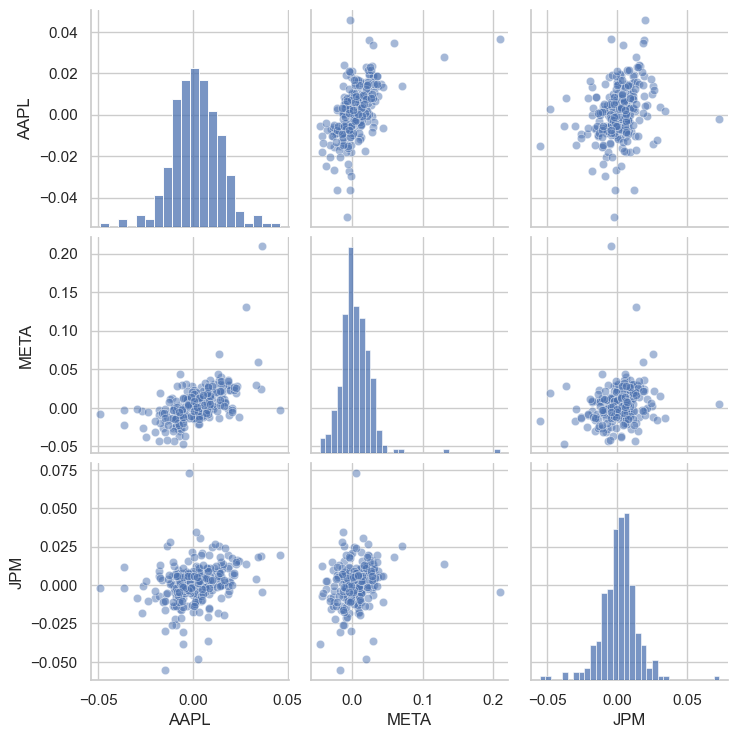

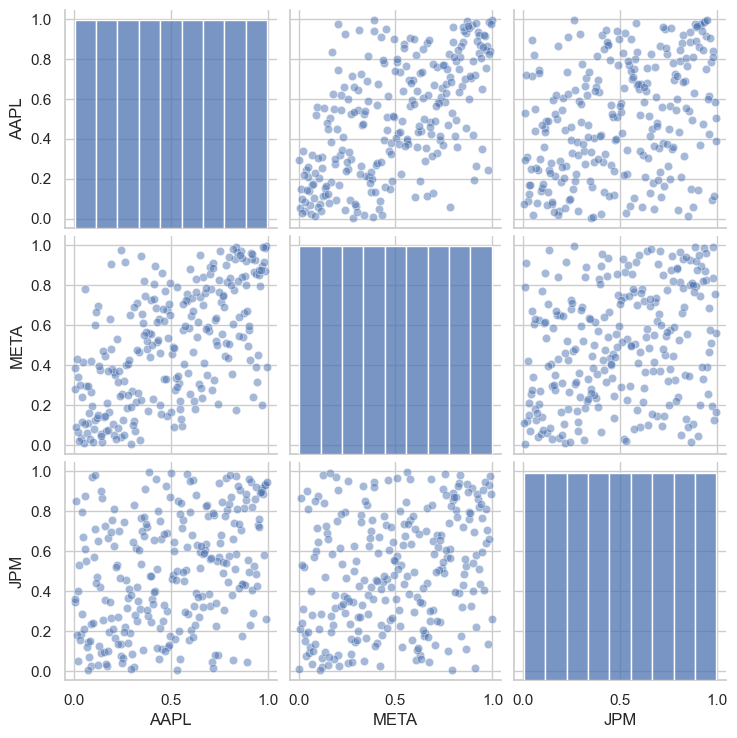

In [375]:
# Compute log-returns and set up the return window (first 252 days)
log_returns = np.log(prices / prices.shift(1)).dropna()
return_window = log_returns[:252]

# Compute the pseudo-observations
U = return_window.rank(method="average", axis=0) / (len(return_window) + 1)

# Plot pairwise scatter plots for log_returns and pseudo-observations
sns.pairplot(return_window[TICKERS], kind="scatter", plot_kws={'alpha': 0.5})
sns.pairplot(U[TICKERS], kind="scatter", plot_kws={'alpha': 0.5})

### b)

In [376]:
# Fit Gaussian copula
copula_gauss = copulae.elliptical.GaussianCopula(dim=len(TICKERS))
copula_gauss.fit(U[TICKERS])
print(copula_gauss.sigma)
print(copula_gauss.params)

# Fit Student-t copula
copula_t = copulae.elliptical.StudentCopula(dim=len(TICKERS))
copula_t.fit(U[TICKERS])
print(copula_t.sigma)
print(copula_t.params)

             AAPL        META         JPM
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
[[1.         0.59791395 0.34277648]
 [0.59791395 1.         0.28697392]
 [0.34277648 0.28697392 1.        ]]
[0.59791395 0.34277648 0.28697392]
             AAPL        META         JPM
count  252.000000  252.000000  252.000000
mean     0.500000    0.500000    0.500000
std      0.288104    0.288104    0.288104
min      0.003953    0.003953    0.003953
25%      0.251976    0.251976    0.251976
50%      0.500000    0.500000    0.500000
75%      0.748024    0.748024    0.748024
max      0.996047    0.996047    0.996047
[[1.         0.59956421 0.34932763]
 [0.59956421 1.         0.30210781]
 [0.34932763 0.30210781 1.  

### c)

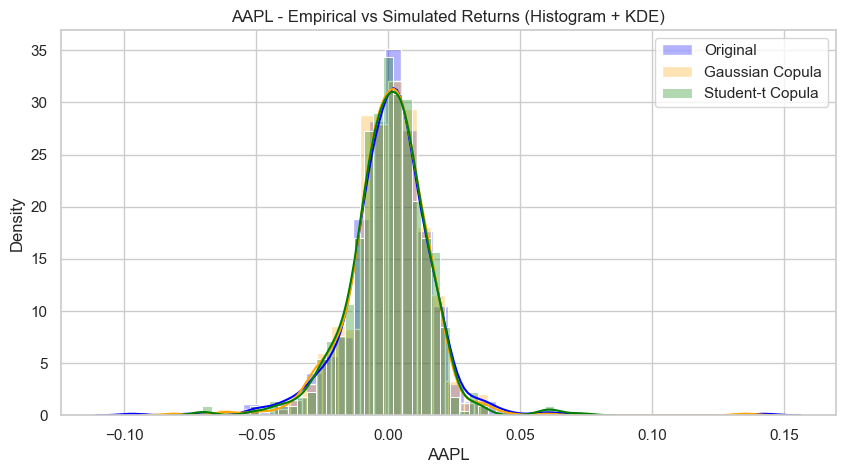

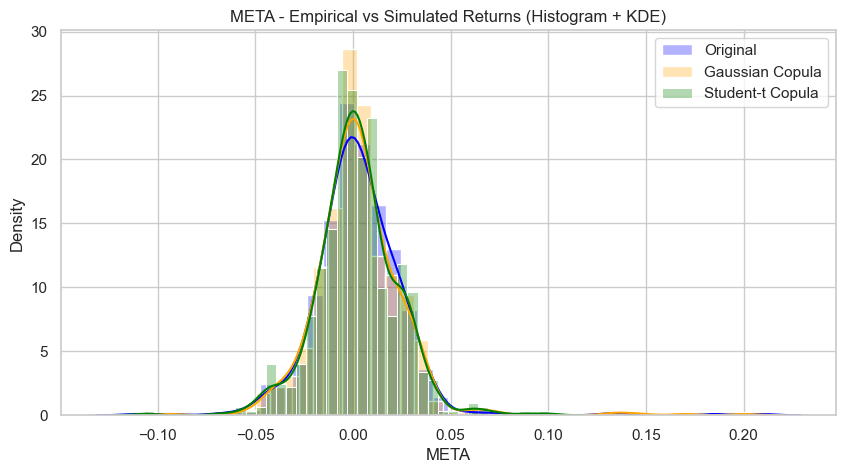

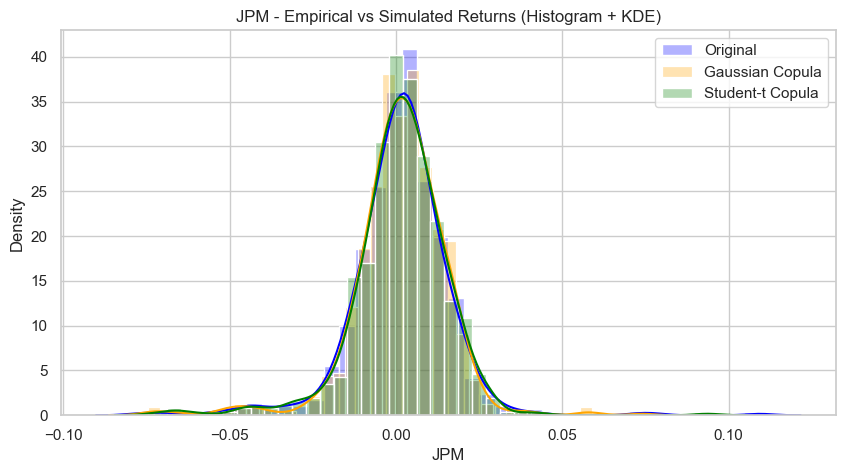

In [377]:
# Number of observations for simulation
T = len(log_returns)

# Simulate samples from the fitted copulas
gauss_samples = copula_gauss.random(T, seed=seed)
t_samples  = copula_t.random(T, seed=seed)

# Convert samples to numpy arrays
gauss_samples = np.asarray(gauss_samples)
t_samples = np.asarray(t_samples)

# Build matrices for simulated returns
gauss_mat = np.zeros_like(gauss_samples)
t_mat = np.zeros_like(t_samples)

# Map quantiles back to log-returns
for j, stock in enumerate(TICKERS):
    data = log_returns[stock].values  
    
    gauss_mat[:, j] = np.quantile(data, gauss_samples[:, j])
    t_mat[:, j] = np.quantile(data, t_samples[:, j])

# Create DataFrames for simulated returns
simulated_gauss_returns = pd.DataFrame(gauss_mat, index=log_returns.index, columns=TICKERS)
simulated_t_returns = pd.DataFrame(t_mat, index=log_returns.index, columns=TICKERS)

# Plot histograms of empirical and simulated returns
for stock in TICKERS:
    plt.figure(figsize=(10, 5))

    sns.histplot(log_returns[stock], bins=40, stat="density", color="blue", alpha=0.3, label="Original")
    sns.kdeplot(log_returns[stock], color="blue")

    sns.histplot(simulated_gauss_returns[stock], bins=40, stat="density", color="orange", alpha=0.3, label="Gaussian Copula")
    sns.kdeplot(simulated_gauss_returns[stock], color="orange")

    sns.histplot(simulated_t_returns[stock], bins=40, stat="density", color="green", alpha=0.3, label="Student-t Copula")
    sns.kdeplot(simulated_t_returns[stock], color="green")

    plt.title(f"{stock} - Empirical vs Simulated Returns (Histogram + KDE)")
    plt.legend()
    plt.show()

## 5) Portfolio VaR/ES with copulas (rolling)

Equal-weighted portfolio of AAPL, MSFT, JPM. Compare univariate models (as in Exercise 3) vs copula-based VaR/ES with rolling windows.

At each time, fit copulas on last W days, simulate N scenarios, estimate VaR/ES from simulated portfolio returns, then backtest.

### a)

In [378]:

# Settings
assets = ["AAPL", "META", "JPM"]
weights = np.array([1/3, 1/3, 1/3])
W = 252
alpha_vals = [0.95, 0.99]
methods = ['Historical', 'Gaussian', 'Student-t', 'AR-GARCH', 'FHS']
M_fhs = 1000   # bootstrap size inside FHS

# Prepare containers: VaR/ES tables indexed by forecast date
forecast_dates = log_returns.index[W:-1]   # forecasts from day W to day T-2 (1-step ahead uses next day)
n_forecasts = len(forecast_dates)

# Create nested dicts: var_tables_port[alpha][method] -> Series indexed by forecast_dates
var_tables_port = {alpha: {method: pd.Series(index=forecast_dates, dtype=float) for method in methods} for alpha in alpha_vals}
es_tables_port  = {alpha: {method: pd.Series(index=forecast_dates, dtype=float) for method in methods} for alpha in alpha_vals}

# Create storage for mu/sigma/df and standardized residuals (DataFrames indexed by forecast_dates)
mu_sigma_tables = {alpha: {} for alpha in alpha_vals}
for alpha in alpha_vals:
    # For each method (except Historical) we store a DataFrame indexed by forecast_dates
    mu_sigma_tables[alpha]['Gaussian'] = pd.DataFrame(index=forecast_dates, columns=['Mu_L','Sigma_L'])
    mu_sigma_tables[alpha]['Student-t'] = pd.DataFrame(index=forecast_dates, columns=['Mu_L','Sigma_L','Df_L'])
    mu_sigma_tables[alpha]['AR-GARCH'] = pd.DataFrame(index=forecast_dates, columns=['Mu_L','Sigma_L'])
    # For FHS we also store standardized residuals per date (object dtype)
    mu_sigma_tables[alpha]['FHS'] = pd.DataFrame(index=forecast_dates, columns=['Mu_L','Sigma_L','Std_Resid_L'])

# Rolling window loop
T_total = log_returns.shape[0]


for i, forecast_date in enumerate(forecast_dates):
    # window positions in log_returns: start = i, end = i+W-1
    window_start = i
    window_end = i + W  
    # portfolio returns in window (equal-weighted)
    R_window = log_returns.iloc[window_start:window_end][assets]
    # portfolio return is mean of components (equal-weighted)
    port_return_window = R_window.mean(axis=1)     
    port_loss_window = -port_return_window         

    #  Historical 
    for alpha in alpha_vals:
        VaR_h, ES_h = historical(port_loss_window.values, alpha)  # adapt if your 'historical' expects pd.Series
        var_tables_port[alpha]['Historical'].iloc[i] = VaR_h
        es_tables_port[alpha]['Historical'].iloc[i]  = ES_h

    #  Gaussian 
    for alpha in alpha_vals:
        VaR_g, ES_g, mu_g, sigma_g = gaussian(port_loss_window.values, alpha)
        var_tables_port[alpha]['Gaussian'].iloc[i] = VaR_g
        es_tables_port[alpha]['Gaussian'].iloc[i]  = ES_g
        mu_sigma_tables[alpha]['Gaussian'].loc[forecast_date, 'Mu_L'] = mu_g
        mu_sigma_tables[alpha]['Gaussian'].loc[forecast_date, 'Sigma_L'] = sigma_g

    #  Student-t 
    for alpha in alpha_vals:
        VaR_t, ES_t, mu_t, sigma_t, df_t = student_t(port_loss_window.values, alpha)
        var_tables_port[alpha]['Student-t'].iloc[i] = VaR_t
        es_tables_port[alpha]['Student-t'].iloc[i]  = ES_t
        mu_sigma_tables[alpha]['Student-t'].loc[forecast_date, 'Mu_L'] = mu_t
        mu_sigma_tables[alpha]['Student-t'].loc[forecast_date, 'Sigma_L'] = sigma_t
        mu_sigma_tables[alpha]['Student-t'].loc[forecast_date, 'Df_L'] = df_t

    #  AR-GARCH   
    for alpha in alpha_vals:
        VaR_ag, ES_ag, mu_ag, sigma_ag = ar_garch(port_loss_window.values,p=0, alpha=alpha)
        # ensure VaR/ES are expressed as losses (your functions may return returns quantiles)
        var_tables_port[alpha]['AR-GARCH'].iloc[i] = VaR_ag
        es_tables_port[alpha]['AR-GARCH'].iloc[i]  = ES_ag
        mu_sigma_tables[alpha]['AR-GARCH'].loc[forecast_date, 'Mu_L'] = mu_ag
        mu_sigma_tables[alpha]['AR-GARCH'].loc[forecast_date, 'Sigma_L'] = sigma_ag

    # FHS 
    for alpha in alpha_vals:
    
        res_ag = fit_ar_garch(port_loss_window.values, p=0)
        VaR_fhs, ES_fhs, _, mu_fhs, sigma_fhs, std_resid_fhs = fhs(res_ag, alpha=alpha, M=M_fhs)
        var_tables_port[alpha]['FHS'].iloc[i] = VaR_fhs
        es_tables_port[alpha]['FHS'].iloc[i]  = ES_fhs
        mu_sigma_tables[alpha]['FHS'].loc[forecast_date, 'Mu_L'] = mu_fhs
        mu_sigma_tables[alpha]['FHS'].loc[forecast_date, 'Sigma_L'] = sigma_fhs

        # store standardized residuals as an object (list/ndarray)
        mu_sigma_tables[alpha]['FHS'].loc[forecast_date, 'Std_Resid_L'] = list(std_resid_fhs)
  

for alpha in alpha_vals:
    var_tables_port[alpha] = pd.DataFrame(var_tables_port[alpha])
    es_tables_port[alpha]  = pd.DataFrame(es_tables_port[alpha])



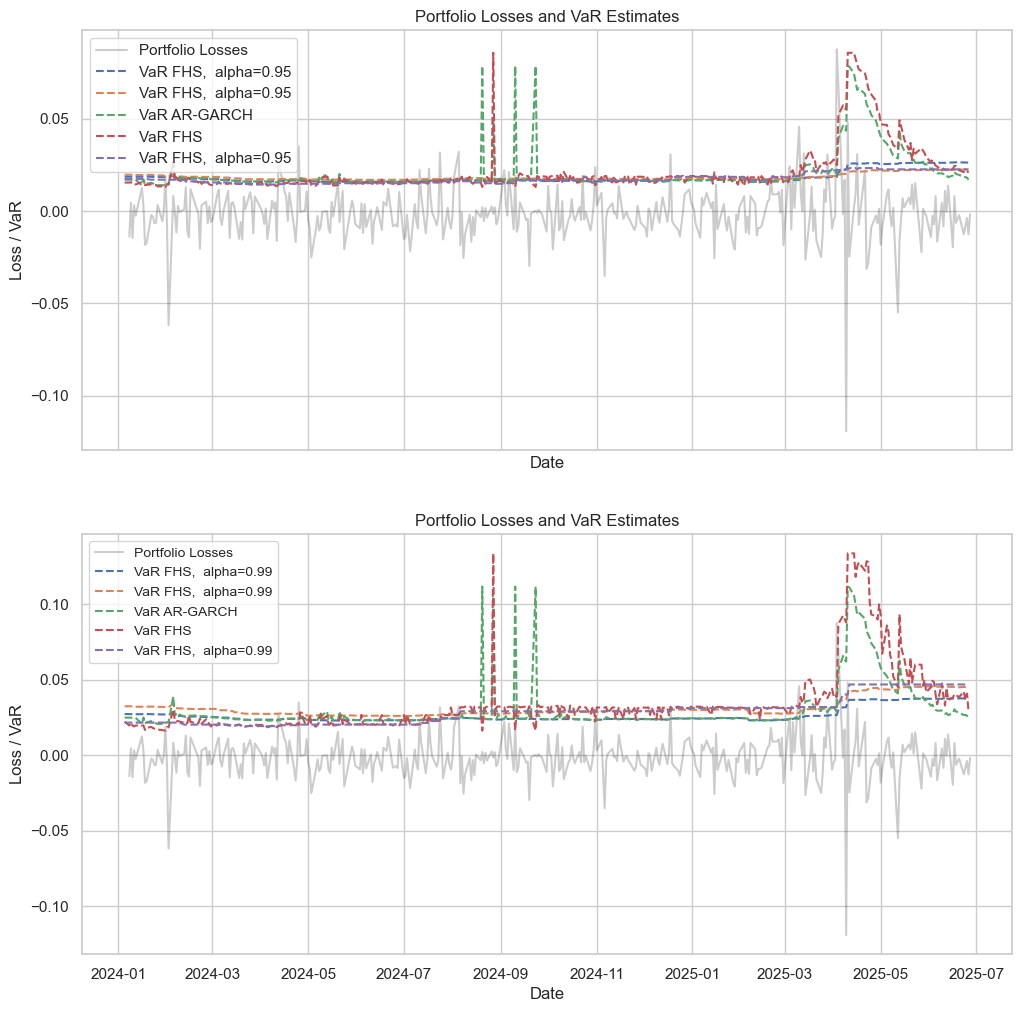

In [379]:
# Plot the portfolio VaR time series for each method as well as the portfolio losses
fig, axes = plt.subplots(len(alpha_vals), 1, figsize=(12, 6*len(alpha_vals)), sharex=True)
port_returns = log_returns[assets].mean(axis=1)

# Function for plotting-friendly clipping
def clip_for_plot(series, q=0.01, upper_q=0.99):
    low  = series.quantile(q)
    high = series.quantile(upper_q)
    return series.clip(lower=low, upper=high)


for j, alpha in enumerate(alpha_vals):
    axes[j].plot(port_returns.index[W+1:], -port_returns[W+1:], label='Portfolio Losses', color='black', alpha=0.2)
    axes[j].plot(forecast_dates, var_tables_port[alpha]["Gaussian"], label=f'VaR {method},  alpha={alpha}', linestyle='--')
    axes[j].plot(forecast_dates, var_tables_port[alpha]["Student-t"], label=f'VaR {method},  alpha={alpha}', linestyle='--')
    axes[j].plot(forecast_dates, clip_for_plot(var_tables_port[alpha]["AR-GARCH"]), label='VaR AR-GARCH', linestyle='--')
    axes[j].plot(forecast_dates, clip_for_plot(var_tables_port[alpha]["FHS"]),label='VaR FHS', linestyle='--')
    axes[j].plot(forecast_dates, var_tables_port[alpha]["Historical"], label=f'VaR {method},  alpha={alpha}', linestyle='--')
    axes[j].set_title(f'Portfolio Losses and VaR Estimates')
    axes[j].set_xlabel('Date')
    axes[j].set_ylabel('Loss / VaR')
    axes[j].legend(loc='upper left')

plt.grid(True)
plt.legend(fontsize='small')
plt.show()

In [380]:
# --- Construct realized portfolio losses aligned with the VaR forecasts ---
realized_returns = log_returns[assets].mean(axis=1)
port_loss = -realized_returns

# realized losses corresponding to forecast_dates
L = port_loss.loc[forecast_dates]

results_list_kup = []
results_list_cond = []
results_list_ind = []

for alpha in alpha_vals:
    for method in methods:

        VaR_hat = var_tables_port[alpha][method].loc[forecast_dates]

        # Run conditional coverage test (Kupiec + independence)
        res = christoffersen_conditional_coverage(L, VaR_hat, alpha)

        res_ind = res["independence"]
        res_kup = res["kupiec"]

        results_list_kup.append({
            "Alpha": alpha,
            "Method": method,
            "LR_pof": res_kup["LR_pof"],
            "p_value_kup": res_kup["pvalue"],
            "Passed_kupiec": res_kup["passed"]
        })

        results_list_cond.append({
            "Alpha": alpha,
            "Method": method,
            "LR_cc": res["LR_cc"],
            "p_value_cc": res["pvalue_cc"],
            "Passed_Cond": res["pvalue_cc"] > 0.05
        })

        results_list_ind.append({
            "Alpha": alpha,
            "Method": method,
            "LR_ind": res_ind["LR_ind"],
            "p_value_ind": res_ind["pvalue"],
            "Passed_Ind": res_ind["passed"]
        })

df_kupiec = pd.DataFrame(results_list_kup)
df_cond   = pd.DataFrame(results_list_cond)
df_ind    = pd.DataFrame(results_list_ind)


In [381]:

L_real = port_loss.loc[forecast_dates].reset_index(drop=True)   # Series length = n_forecasts


M = 1000  
results = []

methods = ["Historical", "Gaussian", "Student-t", "AR-GARCH", "FHS"]

methods = {
    "Historical": sample_historical_factory,
    "Gaussian": sample_gaussian_factory,
    "Student-t": sample_student_t_factory,
    "AR-GARCH": sample_conditional_factory,
    "FHS": sample_fhs_factory
}



for alpha in alpha_vals:

    # pull mu/sigma/df DataFrames
    mu_sig_gauss = mu_sigma_tables[alpha]['Gaussian']
    mu_sig_t     = mu_sigma_tables[alpha]['Student-t']
    mu_sig_ag    = mu_sigma_tables[alpha]['AR-GARCH']
    mu_sig_fhs   = mu_sigma_tables[alpha]['FHS']

    for method_name, factory in methods.items():
        # construct the sampler function appropriate for this method
        if method_name == "Historical":
            sampler = factory(port_loss, W)
        elif method_name == "Gaussian":
            sampler = factory(mu_sig_gauss['Mu_L'].to_numpy(), mu_sig_gauss['Sigma_L'].to_numpy())
        elif method_name == "Student-t":
            sampler = factory(mu_sig_t['Df_L'].to_numpy(), mu_sig_t['Mu_L'].to_numpy(), mu_sig_t['Sigma_L'].to_numpy())
        elif method_name == "AR-GARCH":
            sampler = factory(mu_sig_ag['Mu_L'].to_numpy(), mu_sig_ag['Sigma_L'].to_numpy())
        elif method_name == "FHS":
            sampler = factory(mu_sig_fhs['Mu_L'].to_numpy(), mu_sig_fhs['Sigma_L'].to_numpy(), mu_sig_fhs['Std_Resid_L'].to_numpy())
        method = method_name

        # VaR and ES forecast series for this method and alpha
        q_hat = var_tables_port[alpha][method].values   
        e_hat = es_tables_port[alpha][method].values

        res = es_backtest_parametric(L_real.values, q_hat, e_hat, sampler, M=M)

        results.append({
            "Method": method,
            "Alpha": alpha,
            "Z1": res.get('Z1_obs', np.nan),
            "p_value": res.get('pvalue_one_sided', np.nan),
            "n_used": res.get('n_used', np.nan),
            "n_discarded": res.get('n_discarded', np.nan)
        })

# Build DataFrame with results
results_df = pd.DataFrame(results)
results_df["Passed_ES_test"] = results_df["p_value"] > 0.05


summary = (
    results_df
    .merge(df_kupiec, on=["Method","Alpha"], how="left")
    .merge(df_ind,    on=["Method","Alpha"], how="left")
    .merge(df_cond,   on=["Method","Alpha"], how="left")
)



In [382]:

summary = summary[[
    "Method","Alpha","Z1","p_value","Passed_ES_test",
    "LR_pof","p_value_kup","Passed_kupiec",  
    "LR_ind","p_value_ind","Passed_Ind",   
    "LR_cc","p_value_cc","Passed_Cond"     
]]
print(summary[["Method", "Alpha", "Passed_ES_test","Passed_kupiec","Passed_Ind","Passed_Cond"]])

       Method  Alpha  Passed_ES_test  Passed_kupiec  Passed_Ind  Passed_Cond
0  Historical   0.95           False           True        True         True
1    Gaussian   0.95           False           True        True         True
2   Student-t   0.95           False           True        True         True
3    AR-GARCH   0.95           False           True        True         True
4         FHS   0.95            True           True        True         True
5  Historical   0.99           False          False        True        False
6    Gaussian   0.99           False          False        True        False
7   Student-t   0.99            True          False        True        False
8    AR-GARCH   0.99           False          False        True        False
9         FHS   0.99            True          False        True        False


### b)

In [383]:
import contextlib
import io

import warnings
warnings.filterwarnings("ignore")


# Compute log-returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Window size and parameters
W = 252
alphas = [0.95, 0.99]

# Forecast dates and number of forecasts
forecast_dates = log_returns.index[W:-1]   
n_forecasts = len(forecast_dates)

# To store simulated losses
sim_losses = {
    "Gaussian": [],
    "Student-t": []
}

# For VaR and ES forecasts
var_cop = {a: {"Gaussian": pd.Series(index=forecast_dates),
               "Student-t": pd.Series(index=forecast_dates)}
          for a in alphas}
es_cop  = {a: {"Gaussian": pd.Series(index=forecast_dates),
               "Student-t": pd.Series(index=forecast_dates)}
          for a in alphas}

#Number of simulations
N = 1000  

for i, forecast_date in enumerate(forecast_dates):
    # Define rolling window
    window_start = i
    window_end = i + W  
    R_window = log_returns.iloc[window_start:window_end][TICKERS]
    
    # Compute pseudo-observations
    U = R_window.rank(method="average", axis=0) / (len(R_window) + 1)

    # Fit copulas
    copula_gauss = copulae.elliptical.GaussianCopula(dim=len(TICKERS))
    copula_t = copulae.elliptical.StudentCopula(dim=len(TICKERS))
    
    with contextlib.redirect_stdout(io.StringIO()):
        copula_gauss.fit(U[TICKERS])
        copula_t.fit(U[TICKERS])

    # Simulate samples
    gauss_samples = np.asarray(copula_gauss.random(N, seed=seed))
    t_samples = np.asarray(copula_t.random(N, seed=seed))

    # Map samples back to returns
    gauss_mat = np.zeros_like(gauss_samples)
    t_mat = np.zeros_like(t_samples)

    for j, stock in enumerate(TICKERS):
        data = R_window[stock].values  
        
        gauss_mat[:, j] = np.quantile(data, gauss_samples[:, j])
        t_mat[:, j] = np.quantile(data, t_samples[:, j])
    
    # Compute portfolio returns and losses
    port_gauss_returns = gauss_mat.mean(axis=1)
    port_t_returns = t_mat.mean(axis=1)
    port_gauss_loss = -port_gauss_returns
    port_t_loss = -port_t_returns

    # Store simulated losses
    sim_losses["Gaussian"].append(port_gauss_loss.copy())
    sim_losses["Student-t"].append(port_t_loss.copy())

    for a in alphas:
        # Gaussian copula
        VaR_g = np.quantile(port_gauss_loss, a)
        ES_g = port_gauss_loss[port_gauss_loss >= VaR_g].mean()
        var_cop[a]["Gaussian"].iloc[i] = VaR_g
        es_cop[a]["Gaussian"].iloc[i] = ES_g

        # Student-t copula
        VaR_t = np.quantile(port_t_loss, a)
        ES_t = port_t_loss[port_t_loss >= VaR_t].mean()
        var_cop[a]["Student-t"].iloc[i] = VaR_t
        es_cop[a]["Student-t"].iloc[i] = ES_t

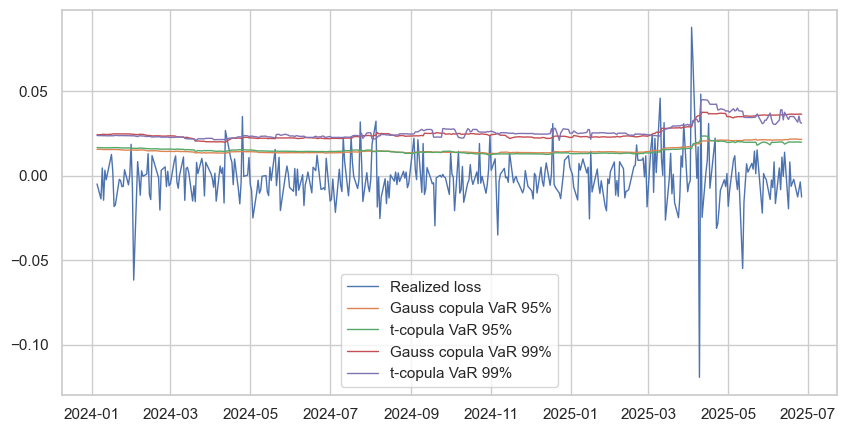

In [384]:
realized_returns = log_returns[TICKERS].mean(axis=1)
L_port = -realized_returns.loc[forecast_dates]

plt.figure(figsize=(10,5))
plt.plot(forecast_dates, L_port, label="Realized loss", linewidth=1)
plt.plot(forecast_dates, var_cop[0.95]["Gaussian"], label="Gauss copula VaR 95%", linewidth=1)
plt.plot(forecast_dates, var_cop[0.95]["Student-t"], label="t-copula VaR 95%", linewidth=1)
plt.plot(forecast_dates, var_cop[0.99]["Gaussian"], label="Gauss copula VaR 99%", linewidth=1)
plt.plot(forecast_dates, var_cop[0.99]["Student-t"], label="t-copula VaR 99%", linewidth=1)
plt.legend()
plt.show()

In [385]:
def sample_copula_factory(sim_losses_model):
    rng = np.random.default_rng(seed)
    def sample(t):
        return rng.choice(sim_losses_model[t])
    return sample

# Compute true losses for the portfolio
realized_returns = log_returns[TICKERS].mean(axis=1)
L = -realized_returns.loc[forecast_dates]

# Prepare to store results
results_kup = []
results_cond = []
results_inds = []
results_es = []

# Models
models = ["Gaussian", "Student-t"]

for alpha in alphas:
    for model in models:

        # VaR backtests
        VaR_hat = var_cop[alpha][model].loc[forecast_dates]   
        res = christoffersen_conditional_coverage(L, VaR_hat, alpha)

        res_ind = res["independence"]
        res_kup = res["kupiec"]

        results_kup.append({
            "Alpha": alpha,
            "Method": model,
            "LR_pof": res_kup["LR_pof"],
            "p_value_kup": res_kup["pvalue"],
            "Passed_kupiec": res_kup["passed"]
        })

        results_cond.append({
            "Alpha": alpha,
            "Method": model,
            "LR_cc": res["LR_cc"],
            "p_value_cc": res["pvalue_cc"],
            "Passed_Cond": res["pvalue_cc"] > 0.05
        })

        results_inds.append({
            "Alpha": alpha,
            "Method": model,
            "LR_ind": res_ind["LR_ind"],
            "p_value_ind": res_ind["pvalue"],
            "Passed_Ind": res_ind["passed"]
        })

        # ES backtest
        ES_hat = es_cop[alpha][model].loc[forecast_dates]

        sampler = sample_copula_factory(sim_losses[model])
        res_es = es_backtest_parametric(L, VaR_hat, ES_hat, M=1000, sample=sampler)

        results_es.append({
            "Method": model,
            "Alpha": alpha,
            "Z1": res_es.get('Z1_obs', np.nan),
            "p_value": res_es.get('pvalue_one_sided', np.nan),
            "n_used": res_es.get('n_used', np.nan),
            "n_discarded": res_es.get('n_discarded', np.nan),
            "Passed_ES_test": res_es.get('pvalue_one_sided', 0) > 0.05
        })

# Convert to DataFrames
df_kup = pd.DataFrame(results_kup)
df_inds = pd.DataFrame(results_inds)
df_cond = pd.DataFrame(results_cond)
df_es = pd.DataFrame(results_es)

# Merge everything
summary_copula = (
    df_es
    .merge(df_kup,  on=["Alpha","Method"])
    .merge(df_inds, on=["Alpha","Method"])
    .merge(df_cond, on=["Alpha","Method"])
)

# Print compact summary like the student did
print(summary_copula[[
    "Method","Alpha","Passed_ES_test",
    "Passed_kupiec","Passed_Ind","Passed_Cond"
]])

      Method  Alpha  Passed_ES_test  Passed_kupiec  Passed_Ind  Passed_Cond
0   Gaussian   0.95           False          False        True        False
1  Student-t   0.95           False          False        True        False
2   Gaussian   0.99           False          False        True        False
3  Student-t   0.99            True          False        True        False
